In [ ]:
import pandas as pd
import pathlib2 as pathlib
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import threshold_yen, threshold_adaptive, threshold_li, threshold_otsu, threshold_isodata, threshold_niblack, threshold_local
from skimage.io import imread, imshow, imshow_collection, imread_collection
from skimage.color import rgb2gray
from scipy import ndimage
from sklearn.cluster import KMeans, AgglomerativeClustering
from skimage import filters, segmentation, transform
from skimage.morphology import dilation, erosion, remove_small_objects
from skimage import feature, exposure
from scipy.ndimage.morphology import binary_fill_holes, binary_opening, binary_closing
import skimage.morphology as morphology
from skimage.segmentation import random_walker
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

In [ ]:
#This function was taken from the https://www.kaggle.com/bonlime/train-test-image-mosaic kernel,
#only as a helper function to plotthe images.. The function was then later modified a little,
#so that it can work with the numpy format data, instead of the pandas dataframe format.
#Also, an additional bool parameter of 'mask' was added, so that this function could plot both
#3D images, and 2D masks as well.
def plot_images(selected_images_df,images_rows=4,images_cols=8,plot_figsize=4, mask = False):
    i = 0
    """Plot image_rows*image_cols of selected images. Used to visualy check clusterization"""
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(plot_figsize*images_cols,images_rows*plot_figsize))
    for row in range(images_rows):
        for col in range(images_cols):
            if (row*images_cols + col) < len(selected_images_df[0]):
                img = selected_images_df[i]
            else:
                continue
            #img = read_image(image_path)
            if mask:
                height, width = img.shape
            else:
                height, width, l= img.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(img)
            i = i + 1
            if i >= len(selected_images_df):
                return

In [ ]:
training_images = list(pathlib.Path('stage1_train').glob('*/images/*.png'))
training_masks = list(pathlib.Path('stage1_train').glob('*/masks/*.png'))
testing_images = list(pathlib.Path('stage1_test').glob('*/images/*.png'))

directory_dictionary = {}

In [ ]:
for i in range(len(training_masks)):
    splitPath = str(training_masks[i]).split('\\')
    #print(splitPath)
    #print(len(splitPath))
    if splitPath[1] not in directory_dictionary:
        #print("if code:")
        #print("new key {} added to the dictionary".format(splitPath[1]))
        directory_dictionary[splitPath[1]] = []
    else:
        #print("else code:")
        #print(splitPath)
        directory_dictionary[splitPath[1]].append(splitPath[3])

In [ ]:
train_X, train_y, test_X = [], [], []

img_ids_train, img_ids_test = [], []

for key, value in directory_dictionary.items():
    #train_X.append(imread(fname='stage1_train/'+key+'/images/'+key+'.png'))
    img_ids_train.append(key)
    #for v in value:
    #    train_y.append(imread(fname='stage1_train/'+key+'/masks/'+v))
for i in range(len(testing_images)):
    splitPath = str(testing_images[i]).split('\\')
    img_ids_test.append(splitPath[1])
    #test_X.append(imread(fname=str(testing_images[i])))
    
nmasks_list = []
for i in range(len(img_ids_train)):
    num_of_masks = len(directory_dictionary[img_ids_train[i]])+1
    nmasks_list.append(num_of_masks)

In [ ]:
del training_images, training_masks, testing_images, directory_dictionary #to save some memory

# Task 1: Understanding of the problem
The following points explain the problem, the dataset, and the expected output:
## Problem:
In this problem, we're going to implement some techniques, through which we can detect the nuclei in some microscopic images. If we're able to successfully automate this problem in an effective way, we can contribute a lot in the domain of health, where doctors can take more accurate, and quicker decisions, after being assisted by the computers programed by us.
## Dataset:
I've figured that the images have three distinct colour-schemes, based on the sample plotted data. There are three distinct dominant colours in the dataset, some images have a dominant black colour, some have a purple dominant colour, and some have the white(greyish) as their dominant colour. Some images have very few, well separated nuclei, whicle others have overlapping, and dense amounts of nuclei, and they'll be obviously hard to deal with. For the training, we're given a 3-dimensional image, and for every 3-dimensional image, we're given multiple 2-dimensional masks. In each mask, every nucleus from the training image is very well separated, and that's why we'll be using this to train our machine learning models.
## Expected output:
We're given a test data, and we need to detect the nuclei in the test data, and compute the masks, and then convert those masks into an RLE format, which is basically a lossless way of storing the locations of the pixels on which the nuclei are present.

# Task 2(a): Pre-processing
First of all, we'll be pre-processing the images, all of them need to be converted into greyscale, for the sake of convenience. In this problem, we're only concerned about the shapes, and locations of the contrast foreground objects, and we're not much concerned with their colours, so greyscale conversion shouldn't cause a huge problem.

Now, our images have been greyscales, and now we won't have to be worried about the RGB channel. All the images have the same colour format now.
Next thing, all of them need to be normalized to the same size.

# Task 3: Implementing a segmentation technique without using neural networks
In this technique, Yen thresholding is used so that background can be separated from the foreground, and labels the segmented foreground objects.

In [746]:
def process_image(img, img_id):
    
    img = exposure.adjust_gamma(image=img, gamma=0.8)
    img = exposure.adjust_log(img, 1)
    #img = exposure.adjust_sigmoid(img)
    #img = remove_small_objects(img,min_size=15)
    #img = feature.canny(img, sigma=2)
    #img = opening(img)
    #img = dilation(img)
    #img = erosion(img)
    
    
#     distance = ndimage.distance_transform_edt(img)
#     local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((20, 20)), labels=img) 
#     markers = morphology.label(local_maxi)
#     labels = watershed(-distance, markers, mask=img)
    
    
    masks = []
    threshold_value = threshold_otsu(img)
    mask = np.where(threshold_value<img, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, num_of_labels = ndimage.label(mask)
    
    labels, num_of_labels = ndimage.label(mask)
    
    images_dataFrame = pd.DataFrame()
    
    for label in range(num_of_labels):
        label_mask = np.where(labels == label, 1, 0)
        label_mask = binary_closing(label_mask,iterations=8)
        label_mask = remove_small_objects(label_mask,min_size=15)
        if label_mask.sum() > 15:
            #label_mask = binary_fill_holes(label_mask).astype(int)
            masks.append(label_mask)
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': img_id, 'EncodedPixels': rle})
            images_dataFrame = images_dataFrame.append(s, ignore_index=True)
    #print(label_mask)
    return images_dataFrame, masks

In [747]:
def generate_output(img_ids):
    test_dir = 'stage1_test'
    output = pd.DataFrame()
    for i in range(len(img_ids)):
        img = imread(test_dir+'/'+img_ids[i]+'/images/'+img_ids[i]+'.png')
        img = rgb2gray(img)
        image_dataframe, masks = process_image(img, img_ids[i])
        output = output.append(image_dataframe, ignore_index=True)
    return output, masks

In [748]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [ ]:
output, temp_mask = generate_output(img_ids_test)
output.to_csv('submission7.csv', index=None)

C:\Python36_64\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


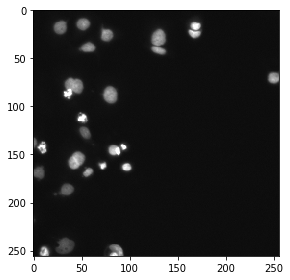

In [749]:
img = img_ids_test[13]
imshow('stage1_test/'+img+'/images/'+img+'.png')

In [750]:
out, masks = generate_output([img])
print(len(masks), img)

22 1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c


C:\Python36_64\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


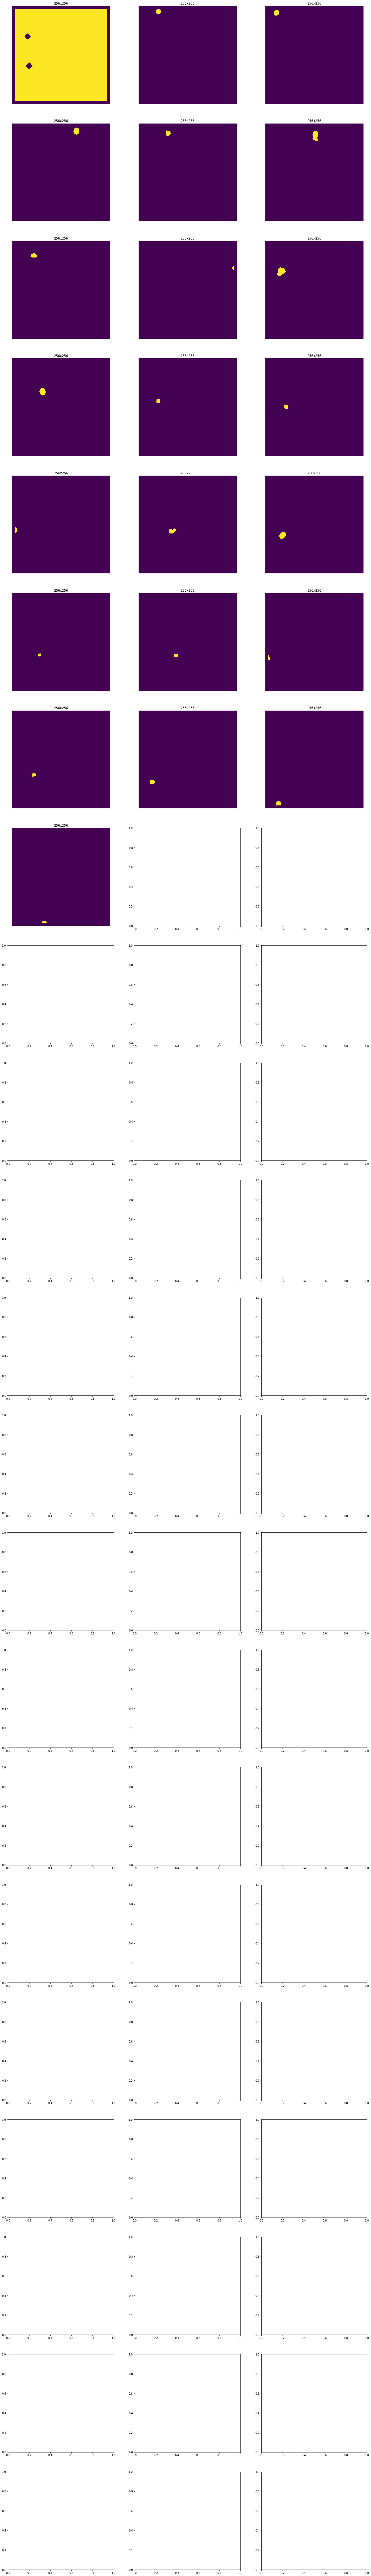

In [751]:
plot_images(masks, int(len(masks)+1/3), 3, 8, True)

Just don't run anything below this point, still working around it.

In [752]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()

In [754]:
print(training_images[0])

stage1_train\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\images\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png


In [774]:
training_masks = list(pathlib.Path('stage1_train').glob('*/masks/*.png'))
training_images = list(pathlib.Path('stage1_train').glob('*/images/*.png'))
j = 0
k = 0
for i in range(len(img_ids_train)):
    X, y = [], []
    for j in range(nmasks_list[i]):
        img = imread(str(training_masks[j]))
        img = rgb2gray(img)
        img = transform.resize(img, output_shape=(200, 200))
        img = np.array(img)
        y.append(img)
    y = np.array(y)
    y = y.flatten()
    y = np.stack(y)
    print(y.shape)
    img = imread(str(training_images[i]))
    img = rgb2gray(img)
    img = transform.resize(img, output_shape=(200, 200))
    img = np.array(img)
    X.append(img)
    X = np.array(X)
    #X = X.transpose(2, 0, 1).reshape(200, -1)
    print(X.shape)
    clf.fit(X[0], y)
    del train_X, train_y
print(len(train_X) == len(train_y_2))
    

C:\Python36_64\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1080000,)
(1, 200, 200)


ValueError: Found input variables with inconsistent numbers of samples: [200, 1080000]

In [ ]:
del train_y_2